In [1]:
import librosa
import numpy as np
import scipy as sp
from presets import Preset
import matplotlib.pyplot as plt
from IPython.display import Audio, display, HTML

lb = Preset(librosa)
lb["sr"] = 44100

In [2]:
x_t = lb.load("examples/x_crop.wav")[0]
y_t = lb.load("examples/y_crop.wav")[0]

In [3]:
print("Original")
display(Audio(data=x_t, rate=44100))
print("Stretched")
display(Audio(data=y_t, rate=44100))

Original


Stretched


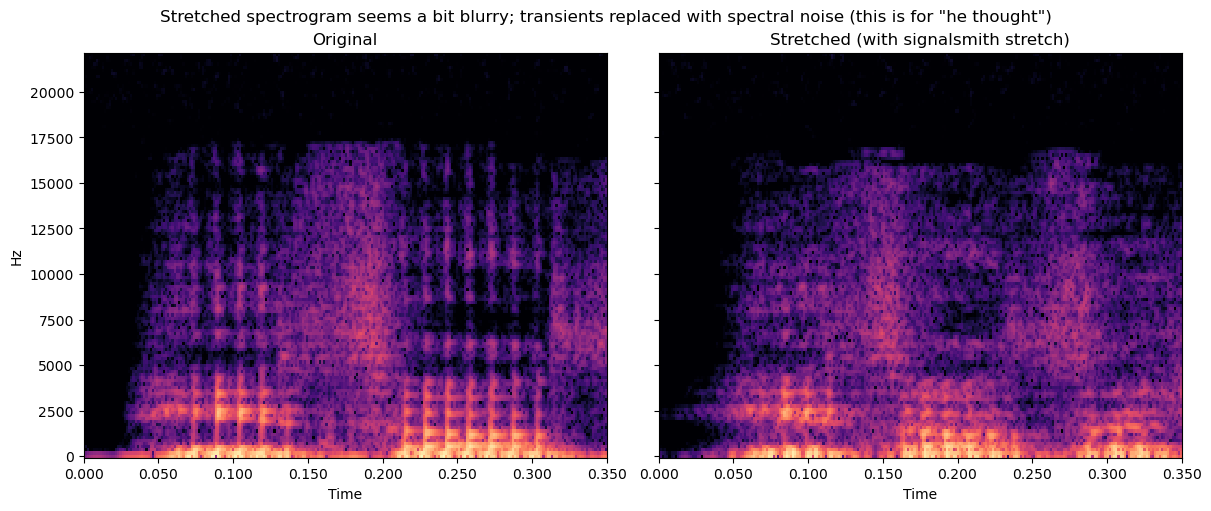

In [4]:
x_f = lb.stft(x_t, hop_length=64, n_fft=256)
y_f = lb.stft(y_t, hop_length=64, n_fft=256)
x_f_dB = lb.amplitude_to_db(np.abs(x_f), ref=np.max)
y_f_dB = lb.amplitude_to_db(np.abs(y_f), ref=np.max)

fig, axs = plt.subplots(ncols=2, sharey=True, layout="constrained")
fig.set_size_inches(12, 5)
lb.display.specshow(x_f_dB, x_axis="time", y_axis="linear", ax=axs[0], hop_length=64, n_fft=256)
lb.display.specshow(y_f_dB, x_axis="time", y_axis="linear", ax=axs[1], hop_length=64, n_fft=256)
axs[0].set(xlim=[0, 0.35], title="Original")
axs[1].set(xlim=[0, 0.35], title="Stretched (with signalsmith stretch)", ylabel="")
plt.suptitle('Stretched spectrogram seems a bit blurry; transients replaced with spectral noise (this is for "he thought")')
fig.savefig("out/stretch-spec-compare.png")

In [16]:
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots()

n_fft = 1024
# zero-pad by 1024 to make plot smoother (zero padding convolves spectrum with sinc)
impulse = np.concatenate([[1], np.zeros(n_fft + 1024 - 1)])
window = sp.signal.windows.hann(n_fft + 1024, sym=False)
freqs = np.fft.rfftfreq(n_fft + 1024, d=1/44100)
psd_lines = ax.plot(freqs, np.zeros((n_fft + 1024) // 2 + 1), label="spectrum", color="C0")[0]
lpc_lines = ax.plot(freqs, np.zeros((n_fft + 1024) // 2 + 1), label="lpc fit", color="C2")[0]
peak_points = ax.plot([], [], marker=".", ls="none", color="red", label="peaks")[0]
ax.set(xlabel="freq (Hz)", ylabel="power (dB)", ylim=[-60, 30], xlim=[20, 8000], title=f"time = 0.0s")
ax.legend()
plt.close()

def is_speech(sample_window: slice):
    t0, t1 = (lb.samples_to_time(n) for n in (sample_window.start, sample_window.stop))
    res = any(((0.06 <= t and t <= 0.14) or (0.205 <= t and t <= 0.31)) for t in (t0, t1))
    return res

min_frame_peaks = []
def update(sample_window: slice):
    assert sample_window.stop - sample_window.start == n_fft
    xw_t = x_t[sample_window]
    xw_f = np.fft.rfft(window * np.concatenate([xw_t, np.zeros(1024)]))
    xw_psd = 20 * np.log10(np.maximum(np.abs(xw_f), 1e-12))
    coeffs = lb.lpc(xw_t, order=100)
    ir_t = sp.signal.lfilter([1], coeffs, impulse)
    ir_f = np.fft.rfft(ir_t, norm="ortho")
    ir_psd = 20 * np.log10(np.maximum(np.abs(ir_f), 1e-12))
    peaks, _ = sp.signal.find_peaks(ir_psd, prominence=3)
    peak_points.set_data(freqs[peaks], ir_psd[peaks])
    lpc_lines.set_ydata(ir_psd)

    if is_speech(sample_window):
        min_frame_peaks.append(freqs[peaks[0]])
        ax.set_title(f"time = {lb.samples_to_time(sample_window.start):.4f}s, min peak = {freqs[peaks[0]]} Hz")
        psd_lines.set_color("C1")
    else:
        ax.set_title(f"time = {lb.samples_to_time(sample_window.start):.4f}s")
        psd_lines.set_color("C0")
    psd_lines.set_ydata(xw_psd)
    return [psd_lines]

sample_windows = [slice(n, n + n_fft) for n in range(0, lb.time_to_samples(0.35) - n_fft, 100)]

ani = FuncAnimation(fig=fig, func=update, frames=sample_windows)
# GitHub doesn't render the rest of the notebook if this is here
# display(HTML(ani.to_jshtml()))
ani.save("out/lpc-anim.mp4")
print(f"lowest spectral peak is {np.min(min_frame_peaks)}")

lowest spectral peak is 86.1328125


In [6]:
# make 50% faster, 1.5x speed, 1.5 samples per original sample
resampled = lb.resample(x_t, orig_sr=44100, target_sr=int(44100 * 1/1.5))
print("Sped up version of recording from signalsmith stretch")
display(Audio(data=y_t, rate=44100))
print("Played at wrong sample rate (Alvin and Chipmunk effect)")
display(Audio(data=resampled, rate=44100))

Sped up version of recording from signalsmith stretch


Played at wrong sample rate (Alvin and Chipmunk effect)


In [7]:
class Stretcher:
    def __init__(self, speedup_factor, hop_length=64, window_length=256, window_name="bartlett"):
        self.speedup_factor = speedup_factor
        self.analysis_hop_length = hop_length
        self.analysis_window_length = window_length

        self.synthesis_hop_length = int(np.ceil(self.analysis_hop_length / speedup_factor))
        self.synthesis_window_length = int(np.ceil(self.analysis_window_length / speedup_factor))
        self.window = sp.signal.windows.get_window(window_name, self.synthesis_window_length)
        
        # does not support slowing it down
        assert self.speedup_factor >= 1
        assert sp.signal.check_NOLA(self.window, 
                                    nperseg=self.synthesis_window_length, 
                                    noverlap=self.synthesis_window_length - self.synthesis_hop_length)

    # makes it 1.5x as fast
    def apply(self, x):
        analysis_frame_intervals = [
            slice(n, n + self.analysis_window_length) 
            for n in range(0, len(x) - self.analysis_window_length, self.analysis_hop_length)
        ]

        synthesis_frame_intervals = [
            slice(n, n + self.synthesis_window_length) 
            for n in range(0, int(len(x) / self.speedup_factor) - self.synthesis_window_length, self.synthesis_hop_length)
        ]

        synthesis_frames = []
        for interval in analysis_frame_intervals:
            frame = x[interval]
            warped_frame = self._warp(frame)
            # center the synthesis window on the analysis frame.
            offset = (self.analysis_window_length - self.synthesis_window_length) // 2
            cropped_frame = warped_frame[offset:offset + self.synthesis_window_length]
            synthesis_frames.append(self.window * cropped_frame)

        output = np.zeros(self.synthesis_window_length + self.synthesis_hop_length * (len(synthesis_frame_intervals) - 1))
        window_sum = np.zeros_like(output)
        for frame, interval in zip(synthesis_frames, synthesis_frame_intervals):
            output[interval] += frame
            window_sum[interval] += self.window
        # normalize by window envelope unless it would explode
        output[window_sum != 0] /= window_sum[window_sum != 0]
        return output
    
    def _warp(self, frame):
        return frame

In [8]:
# stretcher = Stretcher(speedup_factor=1.5, hop_length=128, window_length=512)
# stretcher = Stretcher(speedup_factor=1.5, hop_length=256, window_length=512)
# stretcher = Stretcher(speedup_factor=1.5, hop_length=256, window_length=1024, window_name="hann")
stretcher = Stretcher(speedup_factor=1.5, hop_length=512, window_length=1024, window_name="hann")
print(f"hop length: {stretcher.analysis_hop_length} -> {stretcher.synthesis_hop_length}")
print(f"expected speedup: {stretcher.analysis_hop_length / stretcher.synthesis_hop_length}x")
result = stretcher.apply(x_t)
print("Original")
display(Audio(data=x_t, rate=44100))
print("Overlap-add time stretched")
display(Audio(data=result, rate=44100))
print("Comparison against signalsmith stretch")
display(Audio(data=y_t, rate=44100))

hop length: 512 -> 342
expected speedup: 1.4970760233918128x
Original


Overlap-add time stretched


Comparison against signalsmith stretch


This has less artifacts than the signalsmith stretch version, but unfortunately ended up shifting the pitch as well. Think about why: speech is a combination of noise and glottal pulses passing through the vocal tract. If we squish the pulses together, then we'll end up increasing the perceived frequency! What we actually want is a form of [TD-PSOLA](https://speech.zone/td-psola-the-hard-way/), which tracks these glottal impulses and builds "granules" around those instead. If we drop 1 out of every 3 granules, then our audio will be 2/3 the original length, which is a 1.5x speedup! And this won't be pitch stretched because we worked at the granule level!

Actually, can I do this dropping idea for what I have above instead, without implementing pitch tracking?

In [ ]:
from fractions import Fraction

class DropStretcher:
    def __init__(self, speedup_factor, hop_length=64, window_length=256, max_drop_period=10, window_name="bartlett"):
        self.hop_length = hop_length
        self.window_length = window_length
        self.window = sp.signal.windows.get_window(window_name, self.window_length)
        # (a, b), drop `a` out of every `b` frames
        self.drop_ratio = self._closest_ratio_with_max_denom((speedup_factor - 1) / speedup_factor, max_denom=max_drop_period)
        # does not support slowing it down
        assert speedup_factor >= 1
        # sanity check for window normalization
        assert sp.signal.check_NOLA(self.window, nperseg=self.window_length, noverlap=self.window_length - self.hop_length)

    def apply(self, x):
        i = 0
        frames = []
        should_drop = self._drop_pattern()
        while i < len(x) - self.window_length:
            if not next(should_drop):
                frames.append(x[i:i + self.window_length])
            i += self.hop_length
        # fill a partial frame
        if i < len(x) and not next(should_drop):
            final_frame = np.zeros(self.window_length)
            final_frame[:len(x) - i] = x[i:]
            frames.append(final_frame)
        # overlap-add
        output = np.zeros(self.window_length + self.hop_length * (len(frames) - 1))
        window_sum = np.zeros_like(output)
        for i, frame in enumerate(frames):
            interval = slice(self.hop_length * i, self.hop_length * i + self.window_length)
            output[interval] += self.window * frame
            window_sum[interval] += self.window
        # normalize by window envelope unless it would explode
        output[window_sum != 0] /= window_sum[window_sum != 0]
        return output
    
    def _drop_pattern(self):
        # drop `a` out of every `b` frames
        a, b = self.drop_ratio
        # same as dropping a/b every frame
        fractional_drop_count = 0
        while True:
            fractional_drop_count += Fraction(a, b)
            if fractional_drop_count >= 1:
                fractional_drop_count -= 1
                yield True
            else:
                yield False

    def _closest_ratio_with_max_denom(self, x, max_denom):
        from fractions import Fraction
        fraction = Fraction.from_float(x).limit_denominator(max_denom)
        return fraction.numerator, fraction.denominator

In [10]:
import scipy.io.wavfile as wav
# stretcher = DropStretcher(speedup_factor=1.5, hop_length=64, window_length=128, window_name="bartlett")
# stretcher = DropStretcher(speedup_factor=1.5, hop_length=750, window_length=1500, window_name="bartlett")
# this is what was used for the samples sent to discord
# stretcher = DropStretcher(speedup_factor=1.5, hop_length=512, window_length=1024, window_name="hann")
max_pitch_period = int(np.ceil(44100 / 80))
hop_length = max_pitch_period
window_length = hop_length * 4
# any window will do, but Kaiser with large beta is skinny, so this sounds smoother (?)
stretcher = DropStretcher(1.5, hop_length, window_length, window_name=("kaiser", 20))

result = stretcher.apply(x_t)
print("Original")
display(Audio(data=x_t, rate=44100))
wav.write("out/original.wav", data=x_t.astype(np.float32), rate=44100)
print("Drop-stretched time stretched")
display(Audio(data=result, rate=44100))
wav.write("out/1.5x-drop-ola.wav", data=result.astype(np.float32), rate=44100)
print("Comparison against signalsmith stretch")
display(Audio(data=y_t, rate=44100))
wav.write("out/1.5x-signalsmith-stretch.wav", data=y_t.astype(np.float32), rate=44100)

Original


Drop-stretched time stretched


Comparison against signalsmith stretch


Closer, and with less artifacts than the previous approach, but still doing a pitch shift. I guess I do need to identify pitch periods. 

After messing around for a while, I realized that you actually don't! You only need to mess with PSOLA if you want to have a hop size on the order of the length of a pitch period. The greatest pitch period is going to correspond to the smallest frequency present in the speech. Looking at the peaks from the LPC from earlier, the smallest peak frequency was 86 Hz, which gives a pitch period of 44100/86 = 512.7906976744 samples. This means that hop lengths greater than around 512 shouldn't affect the pitch!

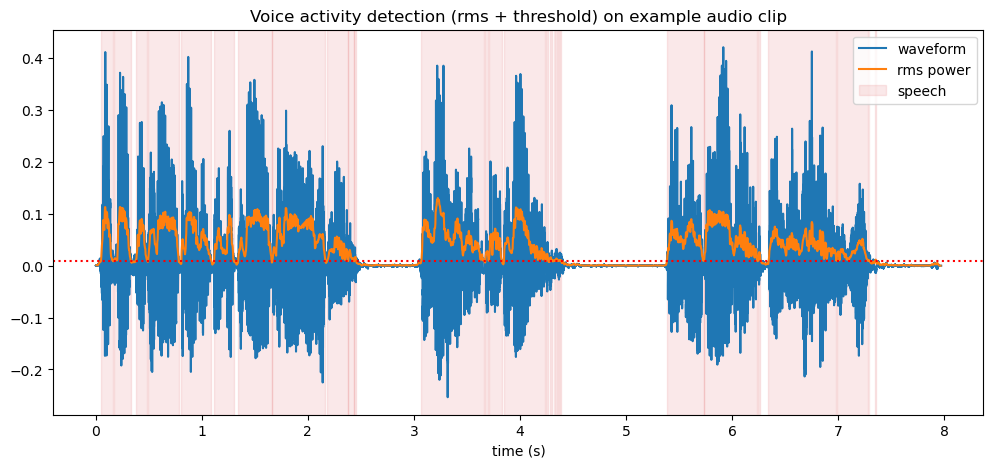

In [11]:
# voice activity detection, see https://speechprocessingbook.aalto.fi/Recognition/Voice_activity_detection.html
# I'd assume audiobook recordings are done well, which means they have good SNR and little extraneous audio
fig, ax = plt.subplots()
fig.set_size_inches(12, 5)
time_samples = lb.samples_to_time(np.arange(len(x_t)))
ax.plot(time_samples, x_t, label="waveform")
frames = lb.util.frame(x_t, frame_length=512, hop_length=128)
rms_power = np.sqrt(np.mean(frames ** 2, axis=0))
time_frames = lb.frames_to_time(np.arange(frames.shape[1]), n_fft=512, hop_length=128)
ax.plot(time_frames, rms_power, label="rms power")
ax.set(xlabel="time (s)", title="Voice activity detection (rms + threshold) on example audio clip")
ax.axhline(y=0.01, color="red", ls="dotted")
is_voice_frame = rms_power > 0.01
voice_on = np.flatnonzero(~is_voice_frame[:-1] & is_voice_frame[1:])
voice_off = np.flatnonzero(is_voice_frame[:-1] & ~is_voice_frame[1:])
for i, (start_idx, stop_idx) in enumerate(zip(voice_on, voice_off)):
    plt.axvspan(time_frames[start_idx], time_frames[stop_idx], color="C3", alpha=0.1, label="speech" if i == 0 else "")
ax.legend()

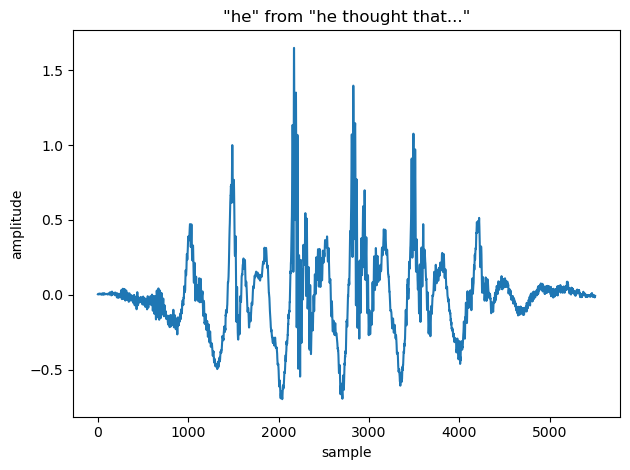

In [12]:
vocal_frames = frames[:, np.arange(voice_on[0], voice_off[0])]
vocal_clip = np.zeros(512 + 128 * (vocal_frames.shape[1] - 1))
for i, frame in enumerate(vocal_frames.T):
    vocal_clip[128 * i:128 * i + 512] += frame
display(Audio(data=vocal_clip, rate=44100))
plt.plot(vocal_clip)
plt.title('"he" from "he thought that..."')
plt.xlabel("sample")
plt.ylabel("amplitude")
plt.tight_layout()

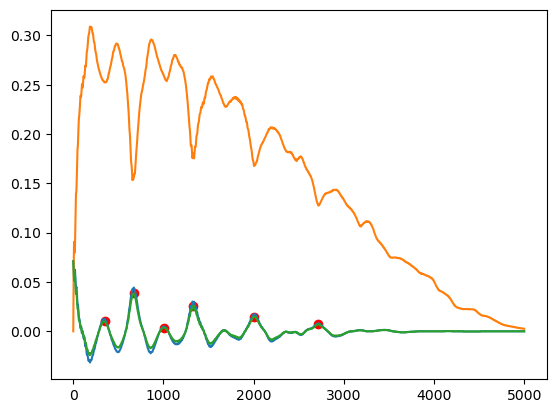

In [13]:
def acf(x, t):
    shape = np.shape(t)
    t = np.atleast_1d(t)
    res = np.zeros_like(t)
    for i, s in enumerate(t):
        if s == 0:
            res[i] = np.sum(x * x)
        else:
            res[i] = np.sum(x[:-s] * x[s:])
    return np.reshape(res / len(x), shape)

def amdf(x, t):
    shape = np.shape(t)
    t = np.atleast_1d(t)
    res = np.zeros_like(t)
    for i, s in enumerate(t):
        if s == 0:
            res[i] = 0
        else:
            res[i] = np.sum(np.abs(x[:-s] - x[s:]))
    return np.reshape(res / len(x), shape)

autocorr = acf(vocal_clip, np.arange(0, 5000))
automag = amdf(vocal_clip, np.arange(0, 5000))
combined = autocorr / (1 + automag)
peaks, properties = sp.signal.find_peaks(combined, prominence=0.01)
plt.plot(autocorr)
plt.plot(automag)
plt.plot(combined)
# autocorrelation = sp.signal.correlate(vocal_clip, vocal_clip, mode="full")[len(vocal_clip):]
# peaks, properties = sp.signal.find_peaks(autocorrelation, prominence=200)
plt.scatter(peaks, combined[peaks], color="red")
# plt.plot(autocorrelation)